In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

In [2]:
# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib as mpl

### set up data

In [3]:
df = pd.read_csv("titanic.csv")
df.shape
print(df.head().to_string())

   survived  pclass     sex   age  sibsp  parch     fare embarked  class    who  adult_male deck  embark_town alive  alone
0         0       3    male  22.0      1      0   7.2500        S  Third    man        True  NaN  Southampton    no  False
1         1       1  female  38.0      1      0  71.2833        C  First  woman       False    C    Cherbourg   yes  False
2         1       3  female  26.0      0      0   7.9250        S  Third  woman       False  NaN  Southampton   yes   True
3         1       1  female  35.0      1      0  53.1000        S  First  woman       False    C  Southampton   yes  False
4         0       3    male  35.0      0      0   8.0500        S  Third    man        True  NaN  Southampton    no   True


In [4]:
df["age_bin"] = pd.qcut(df["age"], q=10)
pdf = df.groupby("age_bin", observed=False, as_index=False).agg(
    **{
        "n": ("age_bin", "size"),
        "survival_rate": ("survived", "mean"),
        "survival_rate_male": (
            "survived",
            lambda x: (
                df.loc[x.index].query("sex == 'male'")["survived"].mean()
                if not x.empty
                else np.nan
            ),
        ),
        "survival_rate_female": (
            "survived",
            lambda x: (
                df.loc[x.index].query("sex == 'female'")["survived"].mean()
                if not x.empty
                else np.nan
            ),
        ),
        "mode_class": ("class", lambda x: x.value_counts().index[0]),
        "median_fare": ("fare", "median"),
        "mode_sex": ("sex", lambda x: x.value_counts().index[0]),
    }
)
print(pdf.head().to_string())

         age_bin   n  survival_rate  survival_rate_male  survival_rate_female mode_class  median_fare mode_sex
0  (0.419, 14.0]  77       0.584416            0.538462              0.631579      Third        27.75     male
1   (14.0, 19.0]  87       0.390805            0.100000              0.783784      Third        10.50     male
2   (19.0, 22.0]  67       0.283582            0.108696              0.666667      Third         8.05     male
3   (22.0, 25.0]  70       0.371429            0.136364              0.769231      Third        13.00     male
4   (25.0, 28.0]  61       0.393443            0.255814              0.722222      Third        13.00     male


### dodge bars

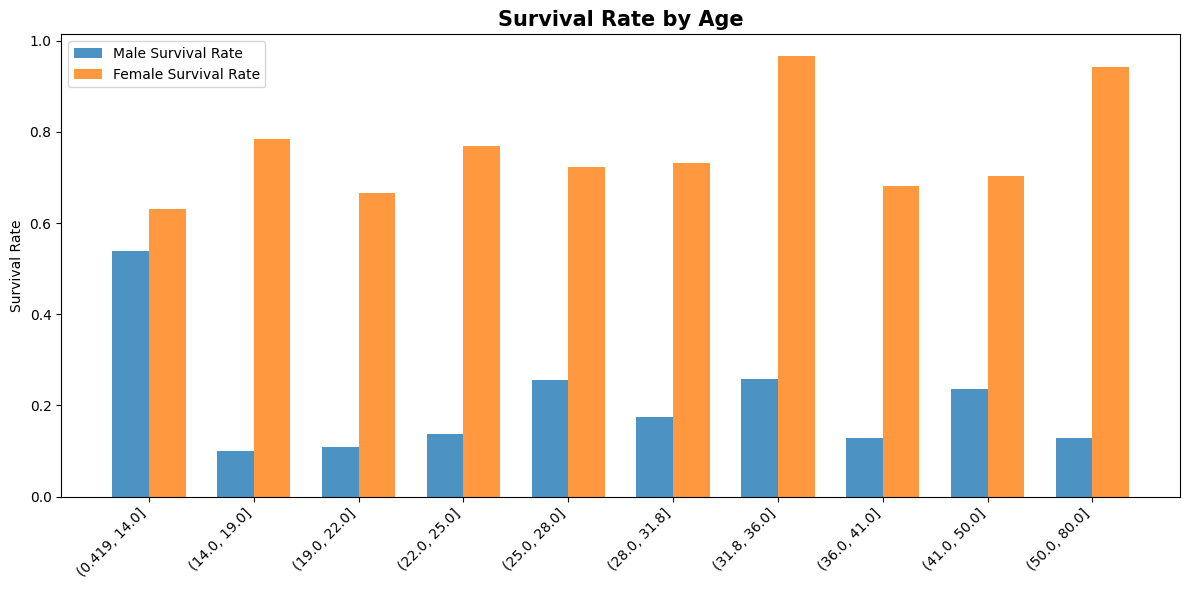

In [ ]:
# line chart
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title(f"Survival Rate by Age", fontsize=15, fontweight="bold")

x_ticklabels = pdf["age_bin"].astype(str)
x = np.arange(len(x_ticklabels))
width = 0.35  # width of the bars

ax.bar(
    x - width/2,
    pdf["survival_rate_male"],
    width=width,
    alpha=0.8,
    label="Male Survival Rate",
)
ax.bar(
    x + width/2,
    pdf["survival_rate_female"],
    width=width,
    alpha=0.8,
    label="Female Survival Rate",
)

ax.set_xticks(x)
ax.set_xticklabels(x_ticklabels, rotation=45, ha="right")
ax.set_ylabel("Survival Rate")
ax.legend()
plt.tight_layout()
plt.show()